## Machine Learning: Profundización

![Colegio Bourbaki](./Images/Bourbaki.png)

### Sistemas de recomendación

En este ejemplo los datos de la competencia de Netflix puesta en Kaggle. (https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data)

#### Contexto

Netflix convocó el concurso abierto Netflix Prize para encontrar el mejor algoritmo que predijera las valoraciones de los usuarios sobre las películas. El gran premio, dotado con 1.000.000 de dólares, lo ganó el equipo Pragmatic Chaos de BellKor. Este es el conjunto de datos que se utilizó en esa competición.

##### Descripción del dataset

El archivo "training_set.tar" es un archivo .tar de un directorio que contiene 17770 archivos, uno por película. La primera línea de cada archivo contiene el identificador de la película seguido de dos puntos. Cada línea posterior del archivo corresponde a una calificación de un cliente y su fecha en el siguiente formato:

CustomerID, Rating, Date

Los MovieIDs van del 1 al 17770 secuencialmente.

Los CustomerIDs van del 1 al 2649429, con espacios. Hay **480189** usuarios.

Las valoraciones están en una escala de cinco estrellas (integral) de 1 a 5.

Las fechas tienen el formato AAAA-MM-DD.

**Películas**

La información de la película en "movie_titles.txt" tiene el siguiente formato:

MovieID, YearOfRelease, Title

Los MovieID no se corresponden con los Id. reales de las películas de Netflix ni con los Id. de las películas de IMDB.

YearOfRelease puede oscilar entre 1890 y 2005 y puede corresponder al lanzamiento de DVD correspondiente, no necesariamente a su estreno en cines.

Title es el título de la película de Netflix y puede no corresponderse con títulos utilizados en otros sitios. Los títulos están en inglés.

**Calificación y Predicción**

El conjunto de datos de calificación para el Premio Netflix está contenido en el archivo de texto "qualifying.txt". Consta de líneas que indican un identificador de película, seguido de
y, a continuación, los identificadores de cliente y las fechas de calificación, una por línea para cada identificador de película.
Los identificadores de la película y del cliente están incluidos en el conjunto de entrenamiento. Por supuesto, las
por supuesto. No hay líneas vacías en el archivo.

MovieID1:

ClienteID11,Fecha11

ClienteID12,Fecha12

...

MovieID2:

ClienteID21,Fecha21

ClienteID22,Fecha22

Para el Premio Netflix, su programa debe predecir todas las valoraciones que los clientes
a las películas del conjunto de datos de calificación basándose en la información del conjunto de datos de
conjunto de datos de entrenamiento.

El formato del archivo de predicción que envíe sigue el orden de id. de película y de cliente,
orden de fecha del conjunto de datos de calificación. Sin embargo, su puntuación predicha sustituye
correspondiente (y fecha), una por línea.

Por ejemplo, si el conjunto de datos de calificación tenía el aspecto siguiente

111:

3245,2005-12-19

5666,2005-12-23

6789,2005-03-14

225:

1234,2005-05-26

3456,2005-11-07

entonces un archivo de predicción debería ser algo así

111:

3.0

3.4

4.0

225:

1.0

2.0

que predice que el cliente 3245 habría valorado la película 111 con 3,0 estrellas el
19 de diciembre de 2005, que el cliente 5666 la habría valorado ligeramente por encima
3,4 estrellas el 23 de diciembre de 2005, etc.

Debe realizar predicciones para todos los clientes y todas las películas del conjunto de datos
del conjunto de datos.

**Testing**

Para que pueda probar su sistema antes de enviar un conjunto de predicciones basado en el
conjunto de datos de calificación, hemos proporcionado un conjunto de datos de sondeo en el archivo "probe.txt".
Este archivo de texto contiene líneas que indican un identificador de película, seguido de dos puntos, y
a continuación, los identificadores de cliente, uno por línea para cada identificador de película.

MovieID1:

ClienteID11

ClienteID12

...

MovieID2:

ClienteID21

ClienteID22

Al igual que en el conjunto de datos de cualificación, los pares de id. de película y de cliente están contenidos en
el conjunto de entrenamiento. Sin embargo, a diferencia del conjunto de datos de calificación, las calificaciones (y las fechas) de cada par se encuentran en el conjunto de datos de entrenamiento.
fechas) de cada par se encuentran en el conjunto de datos de entrenamiento.

Si lo desea, puede calcular el RMSE de sus predicciones con esas
y comparar su RMSE con el RMSE de Cinematch en los mismos datos. Consulte
http://www.netflixprize.com/faq#probe para obtener ese valor.

### Objetivo

El objetivo de esta competencia era mejorar el algoritmo de recomendación 10%. No buscaremos eso por cuestiones de tiempo. Sin embargo, los objetivos de esta notebook son:

* Análisis exploratorio de matriz y por qué es dispersa.
* Implementación de Singular Value Decomposition.
* Implementación de un modelo de sistema de recomendación de filtro colaborativo.
* Generar la predicción de recomendaciones con buen resultado y no.


### Librerias

In [1]:
#!pip install surprise

In [2]:
# Data Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Recommendation System
from surprise import (
    Reader,
    Dataset,
    SVD,
    SVDpp,
)  # Simple Python RecommendatIon System Engine
from surprise.model_selection import cross_validate

**Surprise:**

Surprise es una libreria de Python hecha sobre scikit-learn para construir y analizar sistemas de recomendación que trabajan con datos de valoración explícitos.

Surprise fue diseñado con los siguientes propósitos en mente:

* Dar a los usuarios un control perfecto sobre sus experimentos. Para ello, se ha puesto un gran énfasis en la documentación, que hemos intentado que sea lo más clara y precisa posible señalando cada detalle de los algoritmos.
* Aliviar las molestias del manejo de los conjuntos de datos. Los usuarios pueden utilizar tanto conjuntos de datos integrados (Movielens, Jester) como sus propios conjuntos de datos personalizados.
* Proporciona varios algoritmos de predicción listos para usar, como algoritmos de línea base, métodos de vecindad, basados en factorización matricial (SVD, PMF, SVD++, NMF) y muchos otros. También incorpora varias medidas de similitud (coseno, MSD, Pearson...).
* Facilitar la implementación de nuevas ideas de algoritmos.
* Proporcionar herramientas para evaluar, analizar y comparar el rendimiento de los algoritmos. Los procedimientos de validación cruzada pueden ejecutarse muy fácilmente utilizando potentes iteradores CV (inspirados en las excelentes herramientas de scikit-learn), así como la búsqueda exhaustiva sobre un conjunto de parámetros.

El nombre SurPRISE (más o menos :)) significa Simple Python RecommendatIon System Engine.

Tenga en cuenta que surprise no admite valoraciones implícitas ni información basada en el contenido.

Mas información:
* https://surpriselib.com/

### Carga de datos

En este caso cargar los datos nos llevará un rato por la gran cantidad de registros que tenemos. Sólo cargaremos un archivo, pero la competencia tiene un total de 4 archivos.

In [3]:
df1 = pd.read_csv(
    "./Data/combined_data_1.txt",
    names=["Client_Id", "Rating", "Date"],
    low_memory=True,
    nrows=12 * (10**6),
)

# df2 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_2.txt',
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True)

# df3 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_3.txt',
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True)

# df4 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_4.txt',
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True)
#                 nrows=12*(10**6))

In [4]:
df1.head()

,Client_Id,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


### Analisis exploratorio

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000000 entries, 0 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  object 
 1   Rating     float64
 2   Date       object 
dtypes: float64(1), object(2)
memory usage: 274.7+ MB


Veamos la presencia de datos nulos:

In [6]:
df1.isna().sum()

Client_Id       0
Rating       2340
Date         2340
dtype: int64

En este caso los registros que tenemos con valores nulos corresponden al Id de las películas. Si observamos los registros nulos están ordenados del 1 al 2,340.

In [7]:
df1[df1["Rating"].isna()].shape

(2340, 3)

In [8]:
df1[df1["Rating"].isna()].head()

,Client_Id,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN


In [9]:
movies = df1["Rating"].isna().sum()
print(f"Este es el número de películas que tenemos en este archivo: {movies}")

Este es el número de películas que tenemos en este archivo: 2340


In [10]:
reviews = df1[df1["Rating"].isna() == False]["Client_Id"].count()
print(f"Este es el número de calificaciones: {reviews}")

Este es el número de calificaciones: 11997660


In [11]:
users = df1["Client_Id"].nunique() - movies
print(f"Esta es la cantidad de usuarios que tenemos: {users}")

Esta es la cantidad de usuarios que tenemos: 455716


En este caso no estaremos trabajando con las fechas. Por lo tanto haremos un subconjunto de nuestro DF original.

In [12]:
df1_sub = df1[["Client_Id", "Rating"]]

Ahora observemos como se distribuye la frecuencia para la columna de rating.

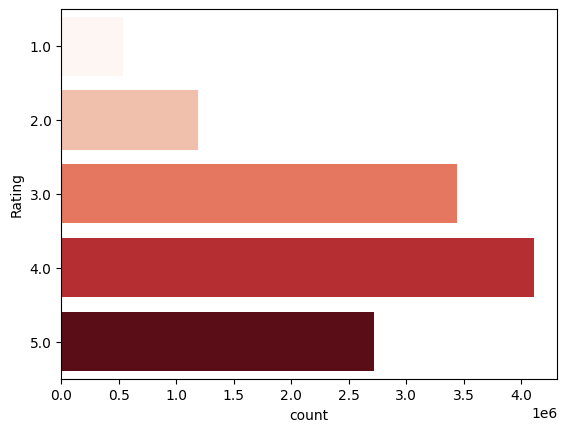

In [13]:
sns.countplot(
    y=df1_sub["Rating"], orient="v", hue=df1_sub["Rating"], palette="Reds", legend=False
)
plt.show()

In [14]:
df1_sub["Rating"].value_counts() / df1_sub["Rating"].count() * 100

Rating
4.0    34.239052
3.0    28.693037
5.0    22.638765
2.0     9.925744
1.0     4.503403
Name: count, dtype: float64

La mayor parte de nuestros valores se distribuyen en los ratings de 3 y 4 estrellas. La mayoría de los rating son positivos.

Volviendo al tema de los valores nulos, los valores nulos que tenemos hacen referencia a Id de 'clientes' con rating vacíos. En realidad esta información es el Id de la película. Lo que debemos hacer ahora es quitar estos registros y añadir los Id's de película como una nueva columna.


In [15]:
# Generamos una serie con valores booleanos. Donde Verdadero será igual al lugar donde hay un Id de película.
pd.isnull(df1_sub["Rating"][:100])

0      True
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: Rating, Length: 100, dtype: bool

In [16]:
# Colocamos la serie como un DataFrame
df1_null = pd.DataFrame(pd.isnull(df1_sub["Rating"]))
df1_null.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [17]:
# Obtenemos sólo los registros de películas junto con índice hasta donde llega los rating para esa película.
df1_null = df1_null[df1_null["Rating"] == True]
df1_null.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [18]:
# Colocamos el índice como columna para tener la ubicación para hasta donde repetir nuestros valores de Id para esa película.
df1_null = df1_null.reset_index()
df1_null.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [19]:
# Inicializamos un contador
movie_id = 1

# Lista para almacenar los IDs de películas
movie_id_array = []

# Iteramos sobre los valores de la columna 'index'
for i, j in zip(df1_null["index"][1:], df1_null["index"][:-1]):
    # Calculamos la cantidad de repeticiones para el ID actual
    repetitions = i - j - 1

    # Usamos np.full directamente para generar la matriz temporal
    temporary = np.full(repetitions, fill_value=movie_id)

    # Añadimos la matriz temporal a la lista
    movie_id_array.extend(temporary)

    # Incrementamos el ID para la siguiente película
    movie_id += 1

# Convertimos la lista a un array numpy al final si es necesario
movie_id_array = np.array(movie_id_array)

In [20]:
movie_id_array, movie_id

(array([   1,    1,    1, ..., 2339, 2339, 2339]), 2340)

In [21]:
# Generamos los Id's para la última película que no está contemplada en nuestro loop.
last_movie = np.full((1, len(df1_sub) - df1_null.iloc[-1, 0] - 1), movie_id)
movie_id_array = np.append(movie_id_array, last_movie)

In [22]:
movie_id_array.shape  # la cantidad de Id's corresponde con la cantidad de películas.

(11997660,)

Ahora para tener todo en orden es necesario que quitemos los registros nulos de nuestro df y añadamos los Id's que generamos.

In [23]:
df1_clean = df1_sub[pd.notnull(df1_sub["Rating"])]

In [24]:
df1_clean.loc[:, "Movie_Id"] = movie_id_array.astype("int16")  # cast a int16

/tmp/ipykernel_22595/333675370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_clean.loc[:, "Movie_Id"] = movie_id_array.astype("int16")  # cast a int16


In [25]:
df1_clean.loc[:, "Client_Id"] = df1_clean["Client_Id"].astype("int32")  # cast a int32

In [26]:
df1_clean.head()

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [27]:
df1_clean.head()

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [28]:
df1_clean.tail()

,Client_Id,Rating,Movie_Id
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340
11999999,1876520,1.0,2340


In [29]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11997660 entries, 1 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  object 
 1   Rating     float64
 2   Movie_Id   int16  
dtypes: float64(1), int16(1), object(1)
memory usage: 297.5+ MB


In [30]:
df1_clean.isnull().sum().sum()

0

#### Analisis Exploratorio: yendo al núcleo

Nuestros datos se encuentran en el formato correcto. Sin embargo, existen muchos datos que no ayudan a nuestra predicción. ¿Por qué sucede esto? En esto momento no parece que tenemos valores nulos, sin embargo no todos los usuarios han calificado las 4,499 películas que tenemos. **De aquí va a provenir nuestra matriz dispersa**.

Pero antes de pasar a la matriz intentemos reducir la cantidad de datos que tenemos removiendo dos casos de nuestro dataset:

1) Las películas que tiene pocas calificaciones.
2) Usuarios que han calificado muy pocas películas.



In [31]:
# Agregamos a nivel película para revisar el conteo y valor promedio para cada una.
movie_agg = df1_clean.groupby("Movie_Id").agg({"Rating": ["count", "mean"]})
movie_agg

Rating          
          count      mean
Movie_Id                 
1           547  3.749543
2           145  3.558621
3          2012  3.641153
4           142  2.739437
5          1140  3.919298
...         ...       ...
2336         91  3.219780
2337       2534  2.426598
2338       3919  3.046696
2339       2418  3.468983
2340       3933  2.954488

[2340 rows x 2 columns]

In [32]:
movie_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2340 entries, 1 to 2340
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Rating, count)  2340 non-null   int64  
 1   (Rating, mean)   2340 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 41.1 KB


In [33]:
movie_agg.describe()

Rating             
               count         mean
count    2340.000000  2340.000000
mean     5127.205128     3.226168
std     15580.298039     0.525592
min        43.000000     1.287879
25%       192.000000     2.894154
50%       569.500000     3.244315
75%      2517.750000     3.612134
max    193941.000000     4.581296

Observamos el comportamiento de la distribución del conteo.

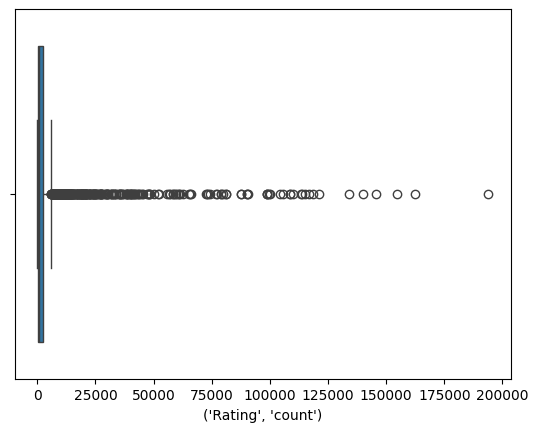

In [34]:
sns.boxplot(x=movie_agg[("Rating", "count")])
plt.show()

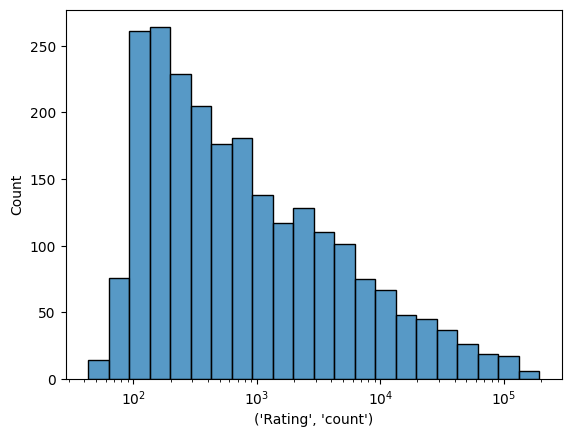

In [35]:
sns.histplot(data=movie_agg, x=("Rating", "count"), log_scale=True)
plt.show()

Por el comportamiento de la distribución del conteo de nuestros ratings observamos que hay un número considerable de películas con un muy pocas calificaciones. Revisemos cuántas son.

In [36]:
# Tomamos el valor del tercer cuartil.
movies_low_rating = movie_agg[("Rating", "count")].quantile(0.75)
movies_low_rating

2517.75

In [37]:
# Seleccionamos todas las películas que están por debajo del valor del cuartil
movies_to_drop = movie_agg[movie_agg[("Rating", "count")] < movies_low_rating].index
movies_to_drop.shape

(1755,)

Ahora observemos el caso del conteo para los usuarios.

In [38]:
user_agg = df1_clean.groupby("Client_Id").agg({"Rating": ["count", "mean"]})["Rating"]
user_agg.head()

,count,mean
Client_Id,,
6,76,3.289474
7,93,4.107527
8,11,3.909091
10,26,3.384615
25,2,3.500000


In [39]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455716 entries, 6 to 2649429
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   count   455716 non-null  int64  
 1   mean    455716 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 10.4 MB


In [40]:
user_agg.describe()

,count,mean
count,455716.000000,455716.000000
mean,26.327055,3.680549
std,38.074139,0.627960
min,1.000000,1.000000
25%,5.000000,3.333333
50%,13.000000,3.691489
75%,33.000000,4.000000
max,2327.000000,5.000000


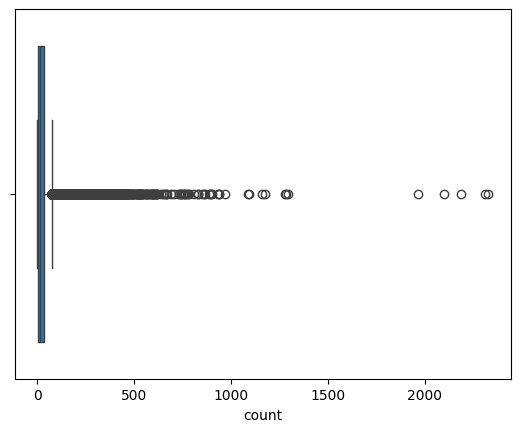

In [41]:
sns.boxplot(x=user_agg["count"])
plt.show()

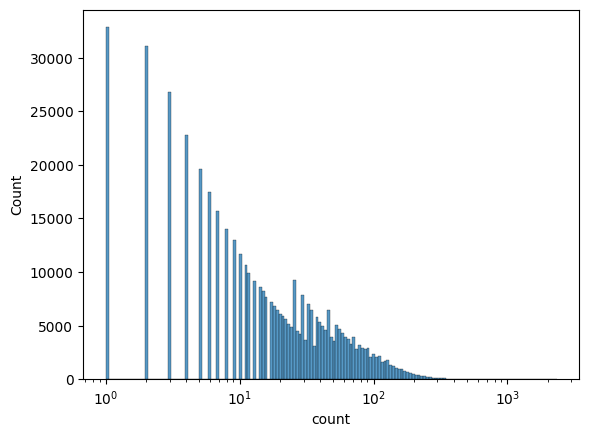

In [42]:
sns.histplot(data=user_agg, x="count", log_scale=True)
plt.show()

In [43]:
user_low_rating = user_agg["count"].quantile(0.75)
user_low_rating

33.0

In [44]:
users_to_drop = user_agg[user_agg["count"] < user_low_rating].index
users_to_drop.shape

(340160,)

Removamos las películas con bajo número de calificaciones tanto los usuarios con pocas películas calificadas.

In [45]:
df1_trim = df1_clean[~df1_clean["Movie_Id"].isin(movies_to_drop)]

In [46]:
df1_clean.shape, df1_trim.shape

((11997660, 3), (11000284, 3))

In [47]:
df1_trim = df1_clean[~df1_clean["Client_Id"].isin(users_to_drop)]

In [48]:
df1_clean.shape, df1_trim.shape

((11997660, 3), (8447711, 3))

In [49]:
df1_trim.shape[0] / df1_clean.shape[0]

0.7041132187443218

Eliminamos el 30% de nuestros datos.

### Preparación de los datos

Vamos a convertir los datos en una matriz de valoración.

In [50]:
# Convirtiendo a matriz dispersa o generando nuestra tabla Usuario-Item
a = df1_trim.copy()
a["Movie_Id"].value_counts().sort_index().index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340],
      dtype='int16', name='Movie_Id', length=2340)

In [51]:
movies_to_drop

Index([   1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
       ...
       2324, 2325, 2327, 2328, 2330, 2333, 2334, 2335, 2336, 2339],
      dtype='int16', name='Movie_Id', length=1755)

In [52]:
# Por limitantes de la ramm, no podemos crearlo, pero en local o usando otras herramientas, podrían
pivot_user_item = df1_trim.pivot(
    index="Client_Id", columns="Movie_Id", values="Rating"
).fillna(0)

In [53]:
pivot_user_item

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340
Client_Id,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2649378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Factorización de Matrices: Singular Value Decomposion.

SVD (Descomposición en Valores Singulares, por sus siglas en inglés) es una técnica de factorización de matrices que descompone una matriz en tres matrices más simples: una matriz de izquierda singular, una matriz diagonal singular y una matriz de derecha singular.

La descomposición en valores singulares es ampliamente utilizada en diversas áreas, incluyendo procesamiento de señales, procesamiento de imágenes, aprendizaje automático y **sistemas de recomendación**. En el contexto de sistemas de recomendación, la SVD se utiliza comúnmente para realizar factorización de matrices en el ámbito de la recomendación colaborativa.

La idea central detrás de la SVD es encontrar una representación latente de los datos, donde cada ítem y cada usuario están descritos por un conjunto de características (vectores de factores latentes). Al descomponer la matriz original en matrices de características, es posible aproximar la matriz original al multiplicar estas matrices de características.

En sistemas de recomendación, la SVD se utiliza para predecir las calificaciones de los usuarios para elementos que aún no han sido calificados, basándose en las características latentes aprendidas. Sin embargo, **es importante tener en cuenta que la SVD puede sufrir de problemas de escalabilidad y manejo de datos dispersos**, lo que ha llevado al desarrollo de variantes como SVD truncada y métodos de factorización de matrices más avanzados en sistemas de recomendación modernos.

In [54]:
df1_trim.shape

(8447711, 3)

In [55]:
# Utilizamos las clases y funciones que importamos del módulo surprise (Reader, Dataset, SVD)
reader = Reader()
data = Dataset.load_from_df(
    df1_trim[["Client_Id", "Movie_Id", "Rating"]][:100_000], reader
)  # ,
# reader) # Es necesario pasar en este orden las columnas

# Perform cross-validation with additional metrics
metrics = ["rmse", "mae"]

svd = SVD(n_epochs=100, lr_all=0.00001, reg_all=0.0001, random_state=42)
cross_validate(svd, data, measures=metrics, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0131  1.0085  1.0116  1.0148  1.0056  1.0107  0.0033  
MAE (testset)     0.8156  0.8087  0.8135  0.8147  0.8096  0.8124  0.0028  
Fit time          3.73    4.27    3.82    3.68    4.01    3.90    0.21    
Test time         0.09    0.11    0.16    0.17    0.10    0.13    0.03    


{'test_rmse': array([1.01308437, 1.00846074, 1.01161753, 1.01483219, 1.00564789]),
 'test_mae': array([0.81564781, 0.80868083, 0.81354816, 0.81466388, 0.80959695]),
 'fit_time': (3.7285988330841064,
  4.268844127655029,
  3.823131561279297,
  3.684609889984131,
  4.009293794631958),
 'test_time': (0.09443855285644531,
  0.11495852470397949,
  0.1640021800994873,
  0.16763830184936523,
  0.10246729850769043)}

In [56]:
# svd_pp=SVDpp(n_epochs=100, lr_all=0.00001, reg_all=0.0001, random_state=42)
# cross_validate(svd_pp, data, measures=metrics, cv=5, verbose=True)

![Benchmark](./Images/surprise_benchmarks.png)

Ahora ya tenemos nuestra matriz factorizada y lista para generar recomendaciones. Pero antes de eso es necesario traer el nombre de nuestras películas

### Sistema de recomendación

Hay que utilizar el mismo nombre para la columna del Id de película, esto nos servirá después para cruzar con nuestra recomendación.

In [57]:
import chardet


def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read())
    return result["encoding"]


file_path = "./Data/movie_titles.csv"
encoding = detect_encoding(file_path)
print(f"The file is encoded in: {encoding}")

The file is encoded in: ISO-8859-1


In [58]:
columns = ["Movie_Id", "Year", "Title"]
df_movies = pd.read_csv(
    "./Data/movie_titles.csv", encoding=encoding, names=columns, on_bad_lines="skip"
)  #

In [59]:
df_movies.head()

,Movie_Id,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [60]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17434 entries, 0 to 17433
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Movie_Id  17434 non-null  int64  
 1   Year      17427 non-null  float64
 2   Title     17434 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 408.7+ KB


In [61]:
df_movies.isna().sum()

Movie_Id    0
Year        7
Title       0
dtype: int64

In [62]:
df_movies = df_movies.dropna()

In [63]:
df_movies["Year"] = df_movies["Year"].astype(int)
df_movies["Title"] = df_movies["Title"].astype(str)

In [64]:
df_movies.set_index("Movie_Id", inplace=True)

In [65]:
df_movies.head()

,Year,Title
Movie_Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW


Procedamos con recomendaciones:

In [66]:
# Obtengamos un usuario al azar
random_user_id = np.random.choice(df1_trim["Client_Id"])
random_user_id

1572816

In [67]:
# Veamos qué le ha gustado antes a este usuario (películas que calificó con 5 estrellas)
user = df1_trim[
    (df1_trim["Client_Id"] == random_user_id) & (df1_trim["Rating"] == 5)
].set_index("Movie_Id")
user_rated5_movies = user.join(df_movies)["Title"]
user_rated5_movies

Movie_Id
191     X2: X-Men United
607                Speed
798                 Jaws
1571         Poltergeist
Name: Title, dtype: object

Recordemos que eliminamos de nuestra matriz películas que no tenían una cantidad considerable de calificaciones, así que debemos eliminarlas también de este listado de películas que utilizaremos para recomendar.

In [68]:
movies_to_not_considered = movies_to_drop.to_list() + user_rated5_movies.index.to_list()

In [69]:
create_recom = df_movies.copy()
create_recom = create_recom.reset_index()
create_list_of_possible_movies_to_recommend = create_recom[
    (~create_recom["Movie_Id"].isin(movies_to_not_considered))
]

create_list_of_possible_movies_to_recommend.shape

(15699, 3)

In [70]:
data = Dataset.load_from_df(
    df1_trim[["Client_Id", "Movie_Id", "Rating"]][:100_000], reader
)

trainset = (
    data.build_full_trainset()
)  # cargamos todos nuestros datos en un objeto tipo trainset

svd.fit(trainset)  # Ajustamos nuestros datos a la matriz que factorizamos.

In [71]:
# Obtenemos un Id de una película para estimar su posible valor de calificación.
random_movie_id = create_list_of_possible_movies_to_recommend.sample()
print(random_movie_id)
random_movie_id = random_movie_id.loc[:, "Movie_Id"].values[0]

      Movie_Id  Year      Title
5957      6069  1970  Love Film


In [72]:
# Hacemos la predicción y obtenemos el valor estimado de la calificación.
prediction = svd.predict(random_user_id, random_movie_id)
prediction

Prediction(uid=1572816, iid=6069, r_ui=None, est=3.579979955834599, details={'was_impossible': False})

### Collaborative Filtering

Creamos una función que nos permite obtener un rating:

In [73]:
def obtain_estimated_rating(id_user, id_movie):
    return lambda x: svd.predict()

In [74]:
user_recommendations = create_list_of_possible_movies_to_recommend.copy()
user_recommendations["Estimated_Rating"] = user_recommendations["Movie_Id"].apply(
    lambda x: svd.predict(random_user_id, x).est
)

In [75]:
user_recommendations.head()

,Movie_Id,Year,Title,Estimated_Rating
7,8,2004,What the #$*! Do We Know!?,3.077416
15,16,1996,Screamers,3.204986
16,17,2005,7 Seconds,3.020044
17,18,1994,Immortal Beloved,3.868296
25,26,2004,Never Die Alone,2.913075


In [76]:
user_recommendations.sort_values("Estimated_Rating", ascending=False)

,Movie_Id,Year,Title,Estimated_Rating
17,18,1994,Immortal Beloved,3.868296
27,28,2002,Lilo and Stitch,3.760696
29,30,2003,Something's Gotta Give,3.682812
9577,9757,1993,Homeward Bound: The Incredible Journey,3.579980
12194,12422,2004,The Murder Room,3.579980
...,...,...,...,...
9575,9755,1999,Blood Dolls,3.579980
15,16,1996,Screamers,3.204986
7,8,2004,What the #$*! Do We Know!?,3.077416
16,17,2005,7 Seconds,3.020044


Ejercicios:

1) Conceptos Básicos:

    ¿Cómo se define un sistema de recomendación con filtro colaborativo?

    Explica la diferencia entre el filtrado colaborativo basado en usuario y el basado en ítems.

    ¿Qué tipo de información utiliza el filtrado colaborativo para realizar recomendaciones?


2) Matrices de Usuario-Ítem:

    Describe qué representa una matriz de usuario-ítem en el contexto de un sistema de recomendación.

    ¿Qué problemas podrían surgir al trabajar con matrices de usuario-ítem en sistemas de recomendación?


3) Similitud entre Usuarios e Ítems:

    ¿Cómo se calcula la similitud entre dos usuarios en un sistema de recomendación colaborativa?

    Explica el concepto de similitud entre ítems y cómo se puede medir.


4) Métodos de Predicción:

    Menciona algunos métodos comunes para predecir la preferencia de un usuario por un ítem en el filtrado colaborativo.

    ¿Cómo se puede utilizar la regresión lineal en sistemas de recomendación?


5) Problemas y Desafíos:

    ¿Cuáles son algunos de los desafíos comunes en los sistemas de recomendación con filtro colaborativo?

    ¿Cómo se abordan los problemas de la dispersión de datos y la falta de datos en estos sistemas?


6) Evaluación de Modelos:

    Explora las métricas de evaluación comunes para sistemas de recomendación. ¿Cómo se determina la precisión de un modelo? 

    ¿Qué significa el término "sobreajuste" en el contexto de los sistemas de recomendación?


7) Tendencias y Avances:

    ¿Cómo pueden incorporarse técnicas de aprendizaje profundo en estos sistemas?

8) SVD en Sistemas de Recomendación:

    ¿Cómo se utiliza la Descomposición de Valores Singulares (SVD) en sistemas de recomendación?

    Explique el proceso de factorización de matrices utilizando SVD en el contexto de la recomendación de películas.

9) Significado de los Componentes de SVD:

    ¿Qué representan los componentes resultantes de la SVD en el contexto de un sistema de recomendación?

    ¿Cómo se interpretan los valores singulares y los vectores singulares?

10) Reducción de Dimensionalidad con SVD:

    Explique cómo SVD puede utilizarse para realizar la reducción de dimensionalidad en un conjunto de datos de valoraciones de películas.

    ¿Cuál es la importancia de la reducción de dimensionalidad en sistemas de recomendación?

11) **Implementación Práctica:**

    **Realice los mismos pasos para los diferentes datasets que no utilizamos en la presente notebook**

    **¿Cuáles son las consideraciones éticas relacionadas con la implementación de sistemas de recomendación?**

    **Proponer un GridSearchCV para el problema para encontrar parámetros óptimos** (https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv)

Referencias:

* https://github.com/bnak/Recommendations_Engine

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)